# Data block API foundations

In [1]:
#!pip install torch
#!pip install conda
#!pip install matplotlib
#!pip install pandas
#!pip install image
#!pip install -U scikit-learn scipy
#!pip install category_encoders
#!pip install patsy
#!pip install snorkel

In [99]:
%load_ext autoreload
%autoreload 2


%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#https://xavierbourretsicotte.github.io/gaussian_mixture.html
#https://xavierbourretsicotte.github.io/gaussian_mixture.html
#notes

In [100]:

import torch
import torch.nn.functional as F
from torch.nn import init
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

import pandas as pd
import numpy as np

from pathlib import Path
from IPython.core.debugger import set_trace
import pickle, gzip, math, torch, matplotlib as mpl
from torch import tensor

from functools import partial
from typing import *
import re
import os
from collections import defaultdict

from sklearn.metrics import confusion_matrix
from scipy.stats import mode
from scipy.stats import multivariate_normal
#numeric encoding
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
from sklearn.preprocessing import LabelEncoder



#from cs229_main1 import *
#from cs229_labeler import *
#from cs229_model_gmm import *
from gmm import *




import matplotlib.pyplot as plt
from matplotlib import patches
import PIL,os,mimetypes
import json, pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.set_num_threads(2)
#torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

from sklearn.mixture import GaussianMixture

from snorkel.labeling import labeling_function


print(os.listdir("./data/"))

['Small Training Set.csv', 'KDDTest+.csv', '20 Percent Training Set.csv', 'KDDTrain+_20Percent.txt', 'Original NSL KDD Zip.zip', 'KDDTrain+.txt', 'NSL_KDD-master', 'KDDTest-21.txt', 'KDDTest+.txt', 'Field Names.csv', 'NSL_KDD-master.zip', 'ReadMe.txt', 'cs229', 'Attack Types.csv', 'Field Names.docx', 'KDDTrain+.csv']


# Setup Get image files

In [101]:
#ls
Path.ls = lambda x: list(x.iterdir())

PATH = Path('./data/')
JPEGS = 'cs229'
IMG_PATH = PATH/JPEGS

#path = Path('../../../data/cs229/tmp')
path = Path('./data/cs229')
path.ls()

[PosixPath('data/cs229/test'),
 PosixPath('data/cs229/training_attack_types.txt'),
 PosixPath('data/cs229/train')]

In [102]:
path_train = path/'train'
path_test  = path/'test'
img_fn = path_train.ls()[0]
img_fn


PosixPath('data/cs229/train/training.csv')

In [103]:
traindata = pd.read_csv(path_train.ls()[0], header=None,names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','type','success_pred'])
testdata = pd.read_csv(path_test.ls()[0], header=None,names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','type','success_pred'])

#headers
traindata.head()
#one row
#traindata[1:1]


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type,success_pred
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [104]:
# 22  attach catagories
category = defaultdict(list)
category["benign"].append("normal")

# read the attacking mapping file
with open(path/'training_attack_types.txt', 'r') as f:
     for line in f.readlines():
         attack, cat = line.strip().split(' ')
         #print(attack, cat)
         category[cat].append(attack)
     
category

attack_mapping = dict((v,k) for k in category for v in category[k])

for k,v in attack_mapping.items():
     print(k,v)

normal benign
apache2 dos
back dos
mailbomb dos
processtable dos
snmpgetattack dos
teardrop dos
smurf dos
land dos
neptune dos
pod dos
udpstorm dos
ps u2r
buffer_overflow u2r
perl u2r
rootkit u2r
loadmodule u2r
xterm u2r
sqlattack u2r
httptunnel u2r
ftp_write r2l
guess_passwd r2l
snmpguess r2l
imap r2l
spy r2l
warezclient r2l
warezmaster r2l
multihop r2l
phf r2l
named r2l
sendmail r2l
xlock r2l
xsnoop r2l
worm probe
nmap probe
ipsweep probe
portsweep probe
satan probe
mscan probe
saint probe


In [105]:
#add a new column "attack_catagory"
traindata['attack_catagory'] = traindata['type'].map(lambda x: attack_mapping[x])
testdata['attack_catagory'] = testdata['type'].map(lambda x: attack_mapping[x])
testdata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,type,success_pred,attack_catagory
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,dos
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,dos
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,benign
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15,probe
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11,probe


In [106]:
#traindata["type"].values
# traindata.loc[~traindata["type"].isin(["normal"]), 'type'] = 0
# traindata.loc[traindata["type"].isin(["normal"]), 'type'] = 1


In [107]:
count = traindata["type"].value_counts()
print(count)
print("anomoly percentage", count[0]/count.sum())

normal             13449
neptune             8282
ipsweep              710
satan                691
portsweep            587
smurf                529
nmap                 301
back                 196
teardrop             188
warezclient          181
pod                   38
guess_passwd          10
warezmaster            7
buffer_overflow        6
imap                   5
rootkit                4
multihop               2
phf                    2
loadmodule             1
spy                    1
ftp_write              1
land                   1
Name: type, dtype: int64
anomoly percentage 0.5338599555414417


In [108]:
# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','type','success_pred']
col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [109]:
nominal_cols

['protocol_type', 'service', 'flag']

In [110]:
binary_cols

['land',
 'logged_in',
 'root_shell',
 'su_attempted',
 'is_host_login',
 'is_guest_login']

In [111]:
numeric_cols

['duration',
 'src_bytes',
 'dst_bytes',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'num_compromised',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [112]:
# Let's take a look at the binary features
# By definition, all of these features should have a min of 0.0 and a max of 1.0

traindata[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,25192.0,0.000079,0.008910,0.0,0.0,0.0,0.0,1.0
logged_in,25192.0,0.394768,0.488811,0.0,0.0,0.0,1.0,1.0
root_shell,25192.0,0.001548,0.039316,0.0,0.0,0.0,0.0,1.0
su_attempted,25192.0,0.001350,0.048785,0.0,0.0,0.0,0.0,2.0
is_host_login,25192.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
is_guest_login,25192.0,0.009130,0.095115,0.0,0.0,0.0,0.0,1.0


In [113]:
#  the su_attempted column has a max value of 2.0?

traindata.groupby(['su_attempted']).size()

su_attempted
0    25171
1        8
2       13
dtype: int64

In [114]:
# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

traindata['su_attempted'].replace(2, 0, inplace=True)
testdata['su_attempted'].replace(2, 0, inplace=True)
traindata.groupby(['su_attempted']).size()

su_attempted
0    25184
1        8
dtype: int64

In [115]:
# Next, we notice that the num_outbound_cmds column only takes on one value!

traindata.groupby(['num_outbound_cmds']).size()

num_outbound_cmds
0    25192
dtype: int64

In [116]:
# Now, that's not a very useful feature - let's drop it from the dataset

traindata.drop('num_outbound_cmds', axis = 1, inplace=True)
testdata.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

Data Preparation

In [117]:
train_Y = traindata['attack_catagory']
train_x_raw = traindata.drop(['attack_catagory','type'], axis=1)
test_Y = testdata['attack_catagory']
test_x_raw = testdata.drop(['attack_catagory','type'], axis=1)
train_Y.head()


0    benign
1    benign
2       dos
3    benign
4    benign
Name: attack_catagory, dtype: object

In [118]:
target_names = train_Y.unique()
print(target_names)

['benign' 'dos' 'r2l' 'probe' 'u2r']


In [119]:
num_classes = len(np.unique(train_Y))
num_classes

5

# Perform labeling of the traing data using labeling api from snorkel
Labeling functions (LFs) help users encode domain knowledge and other supervision sources programmatically
--Heuristic LFs
--There may other heuristics or "rules of thumb" that you come up with as you look at the data. So long as you can express it in a function, it's a viable LF!

In [120]:
from snorkel.labeling import LabelingFunction


In [121]:
# For clarity, we define constants to represent the class labels for normal, attack, and abstaining.
ABSTAIN = -1
NORMAL = 0
ATTACK = 1

rules: r2l_kdd_rules.pdf
Formulation of heuristic rules for R2L attacks
1. If during an FTP session, large amount is data is sent from source as compared to destination then warezmaster  
    attack can be concluded.

   (duration > 265) ∧
   (protocol = tcp) ∧
   (service = ftp ∨ ftp_data) ∧
   (source_bytes > 265616) ∧
   (destination_bytes = 0)  Warezmaster Attack

2. If a guest has logged in through an FTP connection, and hidden directories are created then warezmaster attack can
   be concluded.
   
   (protocol = tcp) ∧
   (service = ftp ∨ ftp_data) ∧
   (hot > 0) ∧
   (hot <= 2) ∧
   (is_guest_login = 1)  Warezmaster Attack
   
3. (duration > 265) ∧
   (destination_bytes <= 688) ∧
   (is_guest_login = 1)  Warezmaster Attack
   
4. If a user, during an FTP session, triggers notably many hot indicators to be set in a small duration of time then 
   the user maybe downloading illegally posted software from the server
   
   (duration < 5) ∧
   (protocol = tcp) ∧
   (service = ftp ∨ ftp_data) ∧
   (logged_in = 1 ∨ is_guest_login = 1)
   (hot > 25)  Warezclient Attack
   
5. (duration <= 4685) ∧
   (hot > 0) ∧
   (hot <= 25)  not Warezclient Attack 
   
6. (source_bytes > 265616) ∧
    (source_bytes <= 283618)  Warezmaster Attack 

In [127]:
@labeling_function()
def WarezmasterAttack_large_data(x):
    return ATTACK if (x["duration"] > 265) and (x["protocol_type"] == 'tcp') and (x["service"] == "ftp" or x["service"] == "ftp_data") and (x["src_bytes"] >265616) and (x["dst_bytes"] ==0) else ABSTAIN


@labeling_function()
def WarezmasterAttack_guest_login(x):
    return ATTACK if (x["protocol_type"] == 'tcp') and (x["service"] == "ftp" or x["service"] == "ftp_data") and (x["hot"] >0) and  (x["hot"] <=0) and (x["is_guest_login"] == 1) else ABSTAIN

@labeling_function()
def WarezmasterAttack_FTP_connection(x):
    return ATTACK if (x["duration"] > 265) and (x["dst_bytes"] <= 688) and (x["is_guest_login"] == 1) else ABSTAIN

@labeling_function()
def WarezmasterAttack_FTP_session_with_many_hot_indicator(x):
    return ATTACK if (x["duration"] < 5) and (x["protocol_type"] == 'tcp') and (x["service"] == "ftp" or x["service"] == "ftp_data") and (x["logged_in"] ==1) and (x["is_guest_login"] ==1) and (x["hot"] > 25)  else ABSTAIN

@labeling_function()
def WarezmasterAttack_hot_indicator(x):
    return ATTACK if (x["dst_bytes"] > 3299) and (x["hot"] > 25)  else ABSTAIN

@labeling_function()
def WarezmasterAttack_FTP_data_upload(x):
    return ATTACK if (x["src_bytes"] > 265616) and (x["src_bytes"] <= 283618)  else ABSTAIN


In [128]:
from snorkel.labeling import PandasLFApplier

lfs = [WarezmasterAttack_large_data, WarezmasterAttack_guest_login, WarezmasterAttack_FTP_connection, WarezmasterAttack_FTP_session_with_many_hot_indicator, WarezmasterAttack_hot_indicator, WarezmasterAttack_FTP_data_upload ]
# lfs = [WarezmasterAttack_large_data, 
#        WarezmasterAttack_guest_login, 
#        WarezmasterAttack_FTP_connection, 
#        WarezmasterAttack_FTP_connection1, 
#        WarezmasterAttack_FTP_session, 
#        WarezmasterAttack_FTP_session1 ]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=train_x_raw)
#L_dev = applier.apply(df=df_dev)





  0%|          | 0/25192 [00:00<?, ?it/s]



  3%|▎         | 713/25192 [00:00<00:03, 7127.80it/s]



  7%|▋         | 1815/25192 [00:00<00:02, 7971.61it/s]



 12%|█▏        | 2999/25192 [00:00<00:02, 8836.94it/s]



 17%|█▋        | 4209/25192 [00:00<00:02, 9614.63it/s]



 22%|██▏       | 5425/25192 [00:00<00:01, 10258.24it/s]



 26%|██▌       | 6597/25192 [00:00<00:01, 10655.71it/s]



 31%|███       | 7718/25192 [00:00<00:01, 10815.65it/s]



 35%|███▌      | 8939/25192 [00:00<00:01, 11198.87it/s]



 40%|████      | 10121/25192 [00:00<00:01, 11376.96it/s]



 45%|████▌     | 11342/25192 [00:01<00:01, 11613.07it/s]



 50%|████▉     | 12497/25192 [00:01<00:01, 11579.53it/s]



 54%|█████▍    | 13725/25192 [00:01<00:00, 11780.79it/s]



 59%|█████▉    | 14955/25192 [00:01<00:00, 11931.51it/s]



 64%|██████▍   | 16147/25192 [00:01<00:00, 11591.90it/s]



 69%|██████▊   | 17308/25192 [00:01<00:00, 10344.97it/s]



 73%|███████▎  | 18369/25192 [00:01<00:00, 10213.43it/s]



 77%

In [131]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
WarezmasterAttack_large_data,0,[1],0.000516,0.0,0.0
WarezmasterAttack_guest_login,1,[],0.000000,0.0,0.0
WarezmasterAttack_FTP_connection,2,[],0.000000,0.0,0.0
WarezmasterAttack_FTP_session_with_many_hot_indicator,3,[1],0.002064,0.0,0.0
WarezmasterAttack_hot_indicator,4,[1],0.002223,0.0,0.0
WarezmasterAttack_FTP_data_upload,5,[],0.000000,0.0,0.0


In [132]:
L_train

array([[-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       ...,
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1]])

In [135]:
WarezmasterAttack_large_data, WarezmasterAttack_guest_login, WarezmasterAttack_FTP_connection, WarezmasterAttack_FTP_session_with_many_hot_indicator, WarezmasterAttack_hot_indicator, WarezmasterAttack_FTP_data_upload  = (L_train != ABSTAIN).mean(axis=0)
print(f"WarezmasterAttack_large_data coverage: {WarezmasterAttack_large_data * 100:.1f}%")
print(f"WarezmasterAttack_guest_login coverage: {WarezmasterAttack_guest_login * 100:.1f}%")
print(f"WarezmasterAttack_FTP_connection coverage: {WarezmasterAttack_FTP_connection * 100:.1f}%")
print(f"WarezmasterAttack_FTP_session_with_many_hot_indicator coverage: {WarezmasterAttack_FTP_session_with_many_hot_indicator * 100:.1f}%")
print(f"WarezmasterAttack_hot_indicator coverage: {WarezmasterAttack_hot_indicator * 100:.1f}%")
print(f"WarezmasterAttack_FTP_data_upload coverage: {WarezmasterAttack_FTP_data_upload * 100:.1f}%")

WarezmasterAttack_large_data coverage: 0.1%
WarezmasterAttack_guest_login coverage: 0.0%
WarezmasterAttack_FTP_connection coverage: 0.0%
WarezmasterAttack_FTP_session_with_many_hot_indicator coverage: 0.2%
WarezmasterAttack_hot_indicator coverage: 0.2%
WarezmasterAttack_FTP_data_upload coverage: 0.0%


In [148]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
WarezmasterAttack_large_data,0,[1],0.000516,0.0,0.0
WarezmasterAttack_guest_login,1,[],0.000000,0.0,0.0
WarezmasterAttack_FTP_connection,2,[],0.000000,0.0,0.0
WarezmasterAttack_FTP_session_with_many_hot_indicator,3,[1],0.002064,0.0,0.0
WarezmasterAttack_hot_indicator,4,[1],0.002223,0.0,0.0
WarezmasterAttack_FTP_data_upload,5,[],0.000000,0.0,0.0


In [159]:
le = LabelEncoder()
#print(train_Y.astype(str))
le.fit(train_Y.astype(str))
train_Y_trans = le.transform(train_Y.astype(str))

In [160]:
#change to L_dev later
LFAnalysis(L_train, lfs).lf_summary(Y=train_Y_trans)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
WarezmasterAttack_large_data,0,[1],0.000516,0.0,0.0,0,13,0.0
WarezmasterAttack_guest_login,1,[],0.000000,0.0,0.0,0,0,0.0
WarezmasterAttack_FTP_connection,2,[],0.000000,0.0,0.0,0,0,0.0
WarezmasterAttack_FTP_session_with_many_hot_indicator,3,[1],0.002064,0.0,0.0,0,52,0.0
WarezmasterAttack_hot_indicator,4,[1],0.002223,0.0,0.0,0,56,0.0
WarezmasterAttack_FTP_data_upload,5,[],0.000000,0.0,0.0,0,0,0.0


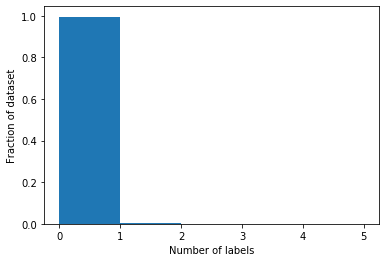

In [149]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

In [150]:
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [151]:
preds_train

array([-1, -1, -1, ..., -1, -1, -1])

In [152]:
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, lr=0.001, log_freq=100, seed=123)

In [153]:
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

NameError: name 'majority_acc' is not defined

# before encoding perform the labeling using snorkel


In [ ]:

combined_df_raw = pd.concat([train_x_raw, test_x_raw])

combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]
# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

In [ ]:
test_x.head()

In [ ]:
train_x['duration'].describe()

In [ ]:
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

In [ ]:
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

In [ ]:
# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

In [ ]:
train_x.describe()

In [ ]:
train_x.head()

In [ ]:
#stanford gmm

Attempting unsupervised learning

In [ ]:
# First, let's visualize the dataset (only numeric cols)

from sklearn.decomposition import PCA

# Use PCA to reduce dimensionality so we can visualize the dataset on a 2d plot
# check this  https://github.com/ggulgun/NIDS-Intrusion-Detection/blob/master/IDS.py
pca = PCA(n_components=7)
train_x_pca_cont = pca.fit_transform(train_x[numeric_cols])

plt.figure(figsize=(15,10))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, category.keys()):
    plt.scatter(train_x_pca_cont[train_Y==cat, 0], train_x_pca_cont[train_Y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

In [ ]:
train_x_pca_cont = train_x_pca_cont[:1000]
print(train_x_pca_cont.shape)

In [ ]:
train_Y.head()

In [ ]:
# Let's create an object of the class LabelEncoder

le = LabelEncoder()
#print(train_Y.astype(str))
le.fit(train_Y.astype(str))
train_Y_trans = le.transform(train_Y.astype(str))
#print(le)
train_Y_trans



#train_Y.head()

In [ ]:
# *** START CODE HERE ***
# (1) Initialize mu and sigma by splitting the n_examples data points uniformly at random
K=4
train_x_pca_cont = train_x_pca_cont[:1000]
n,d = train_x_pca_cont.shape
print(n,d)
group = np.random.choice(K, n)
mu = [np.mean(train_x_pca_cont[group == g, :], axis=0) for g in range(K)]
sigma = [np.cov(train_x_pca_cont[group == g, :].T) for g in range(K)]
print("mu",mu)
print("sigma",sigma)



# into K groups, then calculating the sample mean and covariance for each group
# (2) Initialize phi to place equal probability on each Gaussian
# phi should be a numpy array of shape (K,)
phi = np.full((K,), fill_value=(1. / K), dtype=np.float32)
print("phi",phi)

In [ ]:

#http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/
def plot_axis_pairs(X, axis_pairs, clusters, classes):
    n_rows = len(axis_pairs) // 2
    n_cols = 2
    plt.figure(figsize=(16, 10))
    for index, (x_axis, y_axis) in enumerate(axis_pairs):
        plt.subplot(n_rows, n_cols, index+1)
        plt.title('GMM Clusters')
        plt.xlabel(train_x_pca_cont[x_axis])
        plt.ylabel(train_x_pca_cont[y_axis])
        plt.scatter(
            jitter(X[:, x_axis]), 
            jitter(X[:, y_axis]), 
            #c=clusters, 
            cmap=plt.cm.get_cmap('brg'),
            marker='x')
    plt.tight_layout()
    
def jitter(x):
    return x + np.random.uniform(low=-0.05, high=0.05, size=x.shape)

In [ ]:
exll = []
exll.append((1,2.2))
exll.append((2,3.1))

print(exll)

for items in exll:
    itr,ll = items
    print(itr, " m ")

In [ ]:


# (3) Initialize the w values to place equal probability on each Gaussian
# w should be a numpy array of shape (m, K)

w = np.full((n, K), fill_value=(1. / K), dtype=np.float32)
print("w",w)


# *** END CODE HERE ***


# if is_semi_supervised:
#     w = run_semi_supervised_em(x, x_tilde, z_tilde, w, phi, mu, sigma)
# else:
w, iteration_ll = run_em(train_x_pca_cont, w, phi, mu, sigma)
print("w after em",w)
# Plot your predictions
z_pred = np.zeros(n)
if w is not None:  # Just a placeholder for the starter code
    for i in range(n):
        z_pred[i] = np.argmax(w[i])
is_semi_supervised=False
trial_num=10
#plot_gmm_preds(train_x_pca_cont, z_pred, is_semi_supervised, plot_id=trial_num)
print(z_pred)
plot_axis_pairs(
    X=train_x_pca_cont,
    axis_pairs=[ 
        (0,1), (1,4), 
        (0,2), (1,2),
        (0,3), (1,3)],
    clusters=z_pred,
    classes=["0","1","2","3","4"])

#http://www.oranlooney.com/post/ml-from-scratch-part-5-gmm/

permutation = np.array([
    mode(train_Y_trans[:1000][z_pred == i]).mode.item() 
    for i in range(K)])
permuted_prediction = permutation[z_pred.astype(int)]
print(permuted_prediction)
print(np.mean(train_Y_trans[:1000] == permuted_prediction))
confusion_matrix(train_Y_trans[:1000], permuted_prediction)

#plot of ll and iteration
itrs = []
lls = []
for items in iteration_ll:
    itr, logl = items
    itrs.append(itr)
    lls.append(logl)

plt.figure(figsize=(5, 5))
plt.title('Log-Likelihood')
#plt.plot(np.arange(1, n_epochs + 1), likelihoods)
plt.plot(np.arange(1, len(itrs) + 1), lls)
plt.show()

##how to get mu and sigma? for histogram plot
# import seaborn as sns
# n = 10000 # number of sample to be drawn
# mu = [-6, 5]
# sigma = [2, 3]
# samples = []
# for i in range(n): # iteratively draw samples
#     Z = np.random.choice([0,1]) # latent variable
#     samples.append(np.random.normal(mu[Z], sigma[Z], 1))
# sns.distplot(samples, hist=False)
# plt.show()
# sns.distplot(samples)
# plt.show()

# END